In [1]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
os.chdir('..')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.getcwd()

'/raid/infolab/prateekgarg/work/tiny-discrete-diffusion'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils
from matplotlib import animation
from IPython.display import HTML, display


tensor([9, 0, 5, 6, 0, 7, 6, 1, 8, 7])


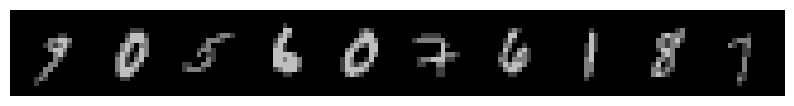

In [3]:
N_TOKENS = 5
RESOLUTION = 14
train_tokens, train_labels, test_tokens, test_labels, token_vals = utils.load_tokenized_mnist(N_TOKENS, RESOLUTION)
tokenized_images = utils.tok2img(train_tokens[33:43], RESOLUTION)
gray_images = token_vals[tokenized_images]
colored_images = gray_images.repeat(1,3, 1, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.viz_images(ax,colored_images, nrow=10)
print(train_labels[33:43])

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
artists = []
for i in range(20):
    tokenized_images = utils.tok2img(train_tokens[33+i:43+i], RESOLUTION)
    gray_images = token_vals[tokenized_images]
    colored_images = gray_images.repeat(1,3, 1, 1)
    ax = utils.viz_images(ax,colored_images, nrow=5)
    containers = ax.get_children()
    artists.append(containers)

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
display(HTML(ani.to_jshtml()));
# display(HTML(ani.to_html5_video()));
plt.close()

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import math

class TimestepEmbedder(nn.Module):
  """
  Embeds scalar timesteps into vector representations.
  """
  def __init__(self, hidden_size, frequency_embedding_size=256):
    super().__init__()
    self.mlp = nn.Sequential(
      nn.Linear(frequency_embedding_size, hidden_size, bias=True),
      nn.SiLU(),
      nn.Linear(hidden_size, hidden_size, bias=True))
    self.frequency_embedding_size = frequency_embedding_size

  @staticmethod
  def timestep_embedding(t, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param t: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an (N, D) Tensor of positional embeddings.
    """
    # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
    half = dim // 2
    freqs = torch.exp(
      - math.log(max_period)
      * torch.arange(start=0, end=half, dtype=torch.float32)
      / half).to(device=t.device)
    args = t[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
      embedding = torch.cat(
        [embedding,
         torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

  def forward(self, t):
    t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
    t_emb = self.mlp(t_freq)
    return t_emb

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Batch First, unnecassarily convoluted but works as expected
        x = x + self.pe[: x.size(1), :].view(1, x.size(1), -1)
        return self.dropout(x)

class Unmasker(nn.Module):
    def __init__(self, vocab_size,n_dim, mask_id=None, embed_dim=128, num_heads=4, num_layers=4, hidden_dim=256, dropout=0.1, ):
        super().__init__()
        self.vocab_size = vocab_size
        self.mask_id = vocab_size - 1 if mask_id is None else mask_id
        self.neg_infinity = -1e9

        self.n_dim = n_dim
        self.tim_embed = TimestepEmbedder(embed_dim, n_dim)
        self.tok_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, dropout=dropout, max_len=n_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, xt, t):
        """
        x: (batch_size, n_dim) Torch.LongTensor
        t: (batch_size) Torch.FloatTensor

        returns: (batch_size, n_dim, vocab_size)
        """
        xt_emb = self.pos_embed(self.tok_embed(xt)) + self.tim_embed(t)[:,None]
        xt_emb = self.encoder(xt_emb)
        logits = self.output_layer(xt_emb) # (batch_size, n_dim, vocab_size)
        return self._subs_param(logits, xt)
    
    def _subs_param(self, logits, xt):
        logits[:,:,self.mask_id] += self.neg_infinity
        logits = logits - torch.logsumexp(logits, dim=-1,keepdim=True) # idk why is this required
        unmasked_indices = (xt != self.mask_id)
        logits[unmasked_indices] = self.neg_infinity
        logits[unmasked_indices, xt[unmasked_indices]] = 0
        return logits

In [6]:
class MaskingScheduler:
    def __init__(self, mode = "linear"):
        self.mode = mode
        self.eps = 1e-6
        self.init_linear_scheduler()
    def init_linear_scheduler(self):
        self.alpha = lambda t : 1 - t
        self.ce_weight = lambda t : -1/(t + self.eps) 

    @torch.no_grad()
    def get_alpha(self, t):
        return self.alpha(t)
    
    @torch.no_grad()
    def get_ce_weight(self, t):
        return self.ce_weight(t)

In [7]:
def compute_loss(x, model, masking_sch, device):
    t = torch.rand(x.shape[0], dtype=torch.float, device=device)
    alpha_t = masking_sch.get_alpha(t).to(device)
    ce_weight_t = masking_sch.get_ce_weight(t).to(device)
    masks = torch.rand_like(x, dtype=torch.float, device=device) < 1 - alpha_t[:,None]
    masked_x = torch.where(masks, torch.tensor(model.mask_id),x)
    logits = model(masked_x, t)
    logprobs = torch.log_softmax(logits, dim=-1)
    B_select = torch.arange(logprobs.shape[0]).reshape(-1,1)
    L_select = torch.arange(logprobs.shape[1])
    out_select = logprobs[B_select,L_select, x]
    loss = (out_select.sum(dim=-1) * ce_weight_t).mean()
    return loss

@torch.no_grad()
def sample(model, n_samples, n_steps, device, masking_sch, return_immediate=False):
    model.eval()
    MASK_IDX = model.mask_id
    samples = torch.zeros(n_samples, model.n_dim, dtype=torch.long, device=device) + MASK_IDX
    if return_immediate:
        all_samples = []
        all_samples.append(samples.cpu())
    time_steps = torch.linspace(0, 1, n_steps+1, device=device)
    for i in range(n_steps,0,-1):
        t = time_steps[i]
        s = time_steps[i-1]
        as_ = masking_sch.get_alpha(s).to(device)
        at_ = masking_sch.get_alpha(t).to(device)
        mu_ = torch.softmax(model(samples, t.repeat(n_samples)), dim=-1)
        c1 = (as_ - at_) / (1 - at_)
        c2 = (1 - as_) / (1 - at_)
        # print(f"{i}: {as_: .02f}, {at_ :.02f}, {c1:.02f}, {c2:.02f}")
        cat_probs = mu_ * c1
        cat_probs[...,MASK_IDX] += c2
        proposed_tokens = utils.multinomial_sample(cat_probs)
        samples[samples == MASK_IDX] = proposed_tokens[samples == MASK_IDX]
        if return_immediate:
            all_samples.append(samples.cpu())
        if (samples == MASK_IDX).sum().item() == 0:
            print("Early Unmasked", n_steps + 1 - i)
            break
    if return_immediate:
        return all_samples
    return samples.cpu()

In [9]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")
model = Unmasker(N_TOKENS + 1, embed_dim=32, num_heads=8, num_layers=8, hidden_dim=16, dropout=0.3, n_dim = RESOLUTION**2).to(device)
# model = Unmasker(N_TOKENS + 1, embed_dim=64, num_heads=8, num_layers=16, hidden_dim=62, dropout=0.3, n_dim = RESOLUTION**2).to(device)
masking_sch = MaskingScheduler()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
N_EPOCHS = 400
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_tokens), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_tokens), batch_size=BATCH_SIZE, shuffle=False)
losses = {
    "train": [],
    "test" : []
}
for epoch in range(N_EPOCHS):
    model.train()
    epoch_train_loss = 0 
    batch_count = 0
    for i, (tokens,) in enumerate(train_loader):
        tokens = tokens.to(device)
        loss = compute_loss(tokens, model, masking_sch, device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * len(tokens)
        batch_count += len(tokens)

    losses["train"].append(epoch_train_loss / batch_count)
    epoch_test_loss = 0
    test_batch_count = 0
    eval_every_epoch = 1
    if epoch % eval_every_epoch == 0:
        with torch.no_grad():
            os.makedirs('saved_models', exist_ok=True)
            torch.save(model.state_dict(), f"saved_models/unmasker_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt")
            model.eval()
            for i, (tokens,) in enumerate(test_loader):
                tokens = tokens.to(device)
                loss = compute_loss(tokens, model, masking_sch, device)
                epoch_test_loss += loss.item() * len(tokens)
                test_batch_count += len(tokens)
            losses["test"].append(epoch_test_loss / test_batch_count)
    print(f"Epoch {epoch: 03}, Train {losses['train'][-1]:.03f}, Test {losses['test'][-1]:.03f}")


Using cuda device


KeyboardInterrupt: 

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Unmasker(N_TOKENS + 1, embed_dim=32, num_heads=8, num_layers=8, hidden_dim=16, dropout=0.3, n_dim = RESOLUTION**2).to(device)
masking_sch = MaskingScheduler()
model.load_state_dict(torch.load(f"saved_models/m1/final_unmasker_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt"))

<All keys matched successfully>

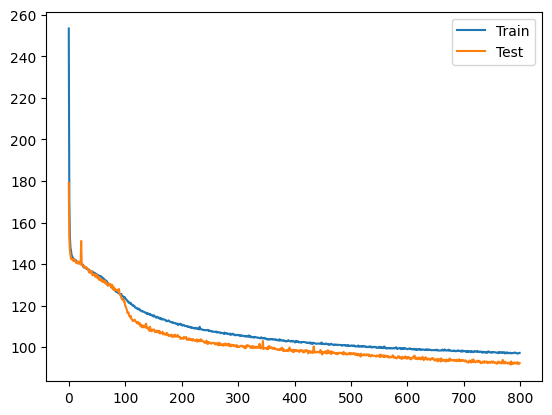

In [19]:
losses = torch.load(f"saved_models/m1/losses.pt")
plt.plot(losses["train"], label="Train")
plt.plot(losses["test"], label="Test")
plt.legend()
plt.show()

Early Unmasked 500


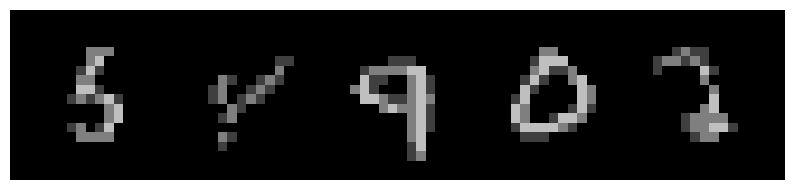

In [92]:
tokenized_samples = sample(model, 5,500, device, masking_sch)
tokenized_samples = utils.tok2img(tokenized_samples, RESOLUTION)
gray_images = token_vals[tokenized_samples]
colored_images = gray_images.repeat(1,3, 1, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.viz_images(ax,colored_images, nrow=10);

## Big Model

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Unmasker(N_TOKENS + 1, embed_dim=64, num_heads=8, num_layers=16, hidden_dim=32, dropout=0.1, n_dim = RESOLUTION**2).to(device)
masking_sch = MaskingScheduler()
model.load_state_dict(torch.load(f"saved_models/m2/final_unmasker_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt"))

<All keys matched successfully>

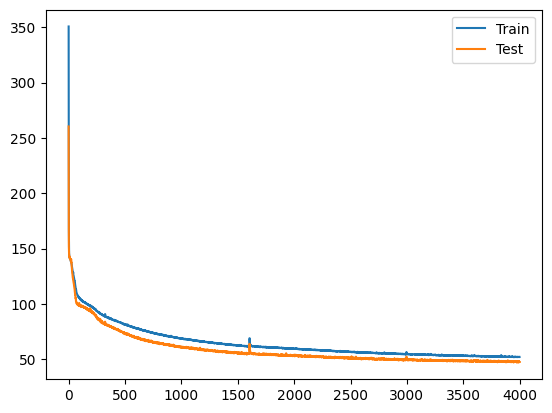

In [23]:
losses = torch.load(f"saved_models/m2/losses.pt")
cutoff = 4000
plt.plot(losses["train"][:cutoff], label="Train")
plt.plot(losses["test"][:cutoff], label="Test")
plt.legend()
plt.show()

Early Unmasked 10
Early Unmasked 100
Early Unmasked 250
Early Unmasked 500
Early Unmasked 1000
Early Unmasked 2000


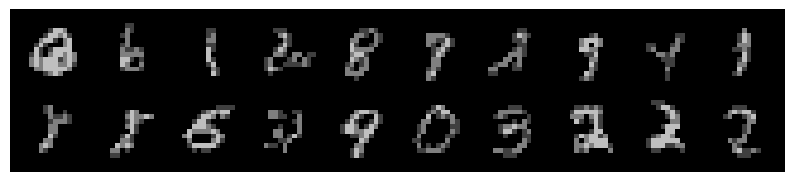

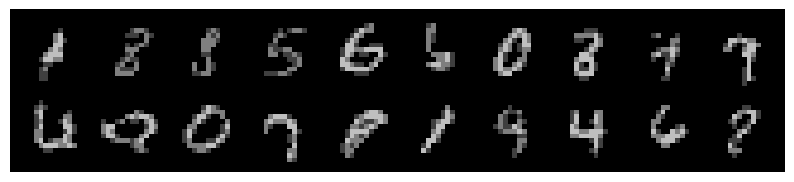

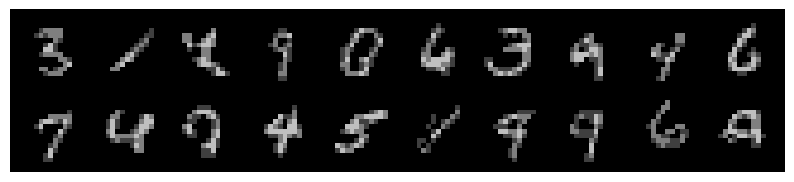

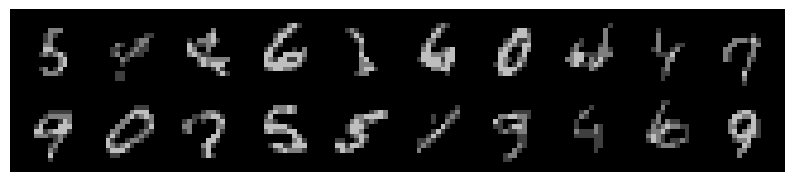

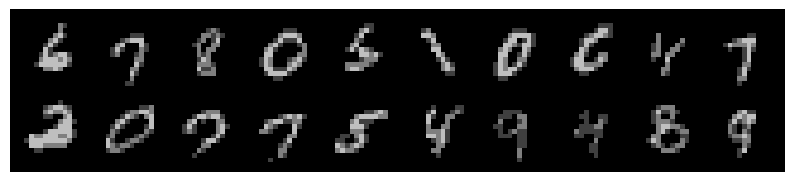

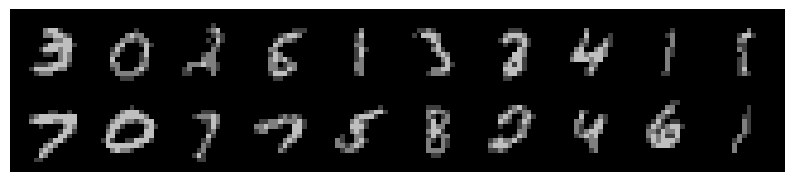

In [9]:
for n_steps in [10,100,250,500,1000,2000]:
    utils.set_seed(32)
    tokenized_samples = sample(model, 20,n_steps, device, masking_sch)
    tokenized_samples = utils.tok2img(tokenized_samples, RESOLUTION)
    gray_images = token_vals[tokenized_samples]
    colored_images = gray_images.repeat(1,3, 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    utils.viz_images(ax,colored_images, nrow=10);

In [24]:
all_samples_sss = sample(model, 25,400, device, masking_sch, return_immediate=True)
processed_samples_sss = []
artists_sss = []
for i, samples_sss in enumerate(all_samples_sss):
    samples_sss = utils.tok2img(samples_sss, RESOLUTION)
    masks_sss = samples_sss == model.mask_id
    samples_sss[masks_sss] = 0
    gray_images_sss = token_vals[samples_sss]
    colored_images_sss = gray_images_sss.repeat(1,3, 1, 1)
    processed_samples_sss.append(utils.mask_img(colored_images_sss,masks_sss, nrow=5))
fig = plt.figure(frameon=False)
fig.set_size_inches(RESOLUTION,RESOLUTION)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
movieImage = ax.imshow(processed_samples_sss[0], aspect='auto')
def animate(i):
    movieImage.set_array(processed_samples_sss[i])
    return movieImage

anim = animation.FuncAnimation(fig,animate,frames=len(processed_samples_sss),interval=0.01, repeat_delay=1000)
plt.close()

Early Unmasked 400


In [25]:
# display(HTML(anim.to_jshtml()));
anim.save(f'assets/md4-mnist.gif', writer='pillow')

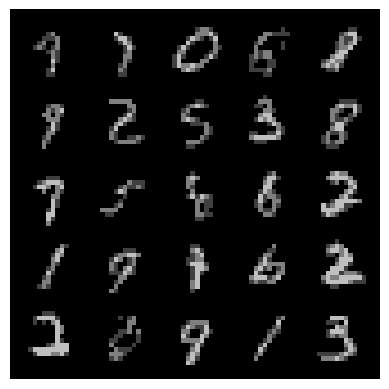

In [32]:
plt.imshow(processed_samples_sss[-1])
plt.axis('off')
plt.show()

In [19]:
import torch
import math
class MaskingScheduler:
    def __init__(self, mode = "linear"):
        self.mode = mode
        self.eps = 1e-6
        if mode == "cosine":
            self.init_cosine_scheduler()
        elif mode == "linear":
            self.init_linear_scheduler()
        else:
            raise NotImplementedError(f"{mode}")
        
    def init_linear_scheduler(self):
        self.alpha = lambda t : 1 - t
        self.ce_weight = lambda t : -1/(t + self.eps) 

    def init_cosine_scheduler(self):
        self.alpha = lambda t : 1 - torch.cos((1 - t) * math.pi / 2)
        self.ce_weight = lambda t : -(math.pi / 2) * torch.tan((1 -t) * math.pi / 2)

    @torch.no_grad()
    def get_alpha(self, t):
        return self.alpha(t)
    
    @torch.no_grad()
    def get_ce_weight(self, t):
        return self.ce_weight(t)

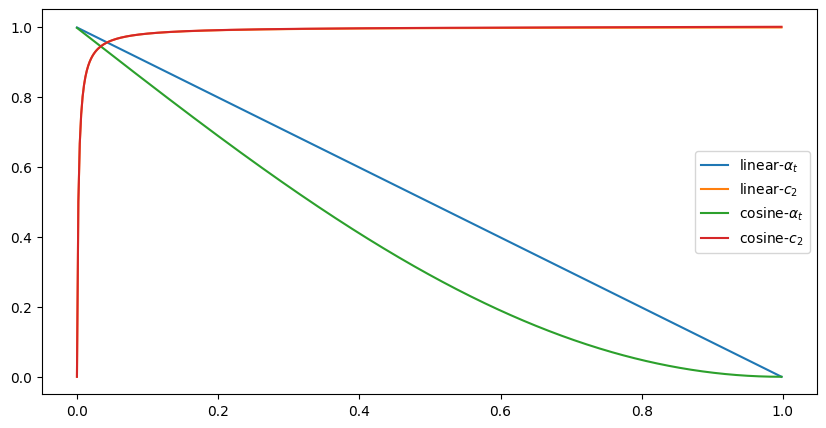

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for mode in ["linear", "cosine"]:
# for mode in ["cosine"]: 
    masking_sch = MaskingScheduler(mode=mode)
    n_steps = 500
    time_steps = torch.linspace(0, 1, n_steps+1)

    t = time_steps[1:]
    s = time_steps[:-1]
    as_ = masking_sch.get_alpha(s)
    at_ = masking_sch.get_alpha(t)
    c2 = (1 - as_) / (1 - at_)

    ax.plot(time_steps[:-1],at_, label=f"{mode}-$\\alpha_t$")
    ax.plot(time_steps[:-1],c2, label=f"{mode}-$c_2$")
    ax.legend()
plt.show()
